# EXPLAINATION  
In this code we will go throught the main steps of PRICE FORECASTING. The aim is the one of predicting the price of flights, using the variable of our dataset. <br>
The main steps performed are Data Cleaning, EDA, and then Modelling. Different models have been trained and tested on the data to find out which one of them was the best <br>
in terms if MAPE (mean absolute percentage error). The best model at the ened turned out to be Random Forrest using parametrs found using the optuna optimization method. <br>
Random forrest defeated Linear regression, Decision Trees, CATBoost and XGBoost.


# Start

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### importing the dataset

In [2]:
# importing the dataset
df=pd.read_csv('flight_dataset.csv')

In [3]:
# retrieving names of columns
df.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

In [4]:
# dropping useless column
df.drop('Unnamed: 0', axis=1,inplace=True)

### informations

In [5]:
df.shape

(300153, 11)

In [6]:
df.dtypes

airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

In [7]:
df.describe()

duration      days_left          price
count  300153.000000  300153.000000  300153.000000
mean       12.221021      26.004751   20889.660523
std         7.191997      13.561004   22697.767366
min         0.830000       1.000000    1105.000000
25%         6.830000      15.000000    4783.000000
50%        11.250000      26.000000    7425.000000
75%        16.170000      38.000000   42521.000000
max        49.830000      49.000000  123071.000000

## Cleaning the dataset

### Duplicates

In [9]:
# checking for duplicates in the whole dataset
df.duplicated().sum()

0

In [10]:
# checking for duplicates in the flight column
df['flight'].duplicated().sum()

298592

In [11]:
df_duplicated = df[df['flight'].duplicated()]

df_duplicated2=df[df[['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration']].duplicated()]

In [13]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [14]:
# this code will give us rows that have everything in common except for the 'days_left' value, 
# effectively filtering out flights that are identical in terms of airline, flight number, cities, times, etc., but differ in how many days are left until the flight
duplicates = df[df.duplicated(subset=['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration'], keep=False) & ~df.duplicated(subset=['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left'], keep=False)]

### NAs

In [15]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

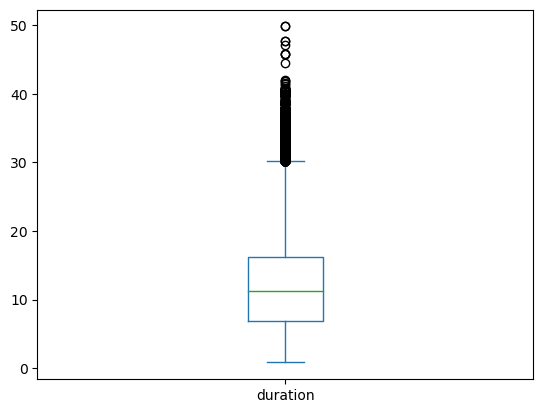

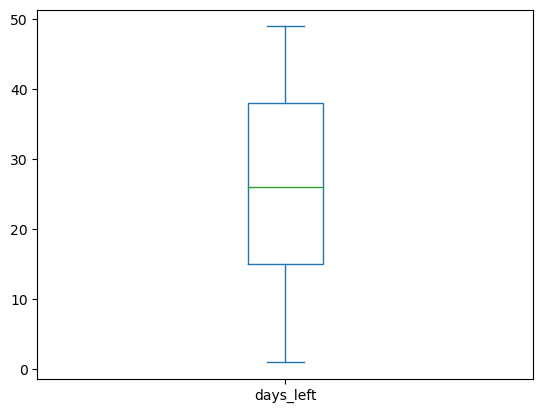

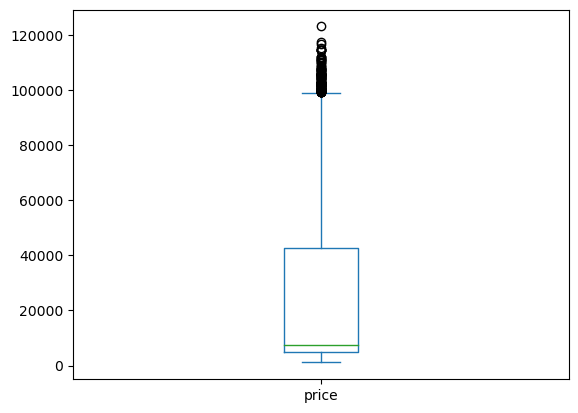

In [16]:
for elem in df.columns[-3:]:
    df[elem].plot(kind='box')
    plt.show()


check if the observation that the boxplot assigns as outliers are effectively outliers or just meaningful observations

In [17]:
df_prova=df[df['duration']>30]

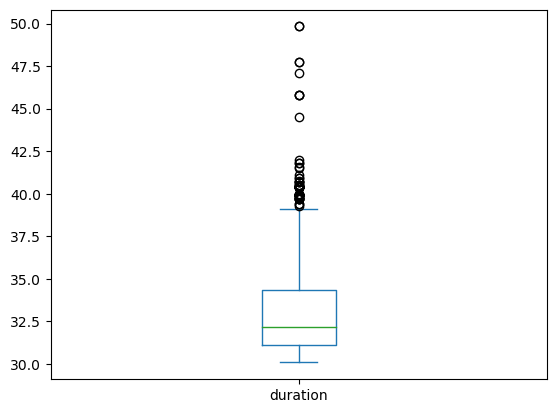

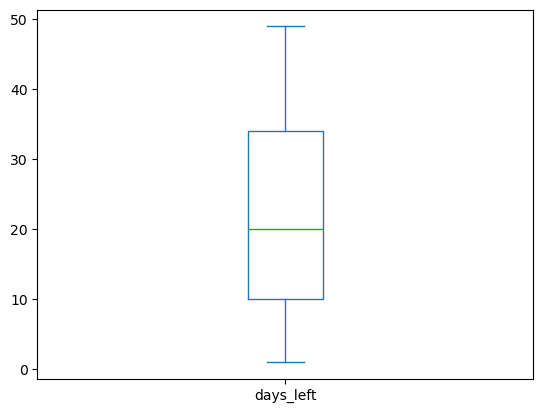

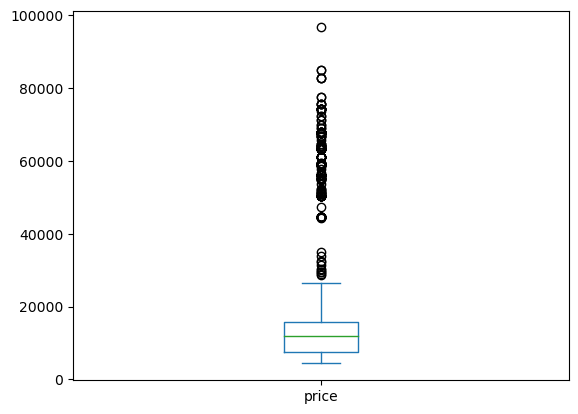

In [18]:
for elem in df_prova.columns[-3:]:
    df_prova[elem].plot(kind='box')
    plt.show()

In [19]:
df_prova['stops'].value_counts()

one            1390
two_or_more     836
Name: stops, dtype: int64

they are all flights with one or more stops, this on average icrease significantly the duration of the total flight so they are not outliers but they are meaningful.

now we should also check the ones that are said to be outliers on the price variable

In [20]:
df_prices=df[df['price']>30000]

In [21]:
df_prices['class'].value_counts()

Business    87583
Economy        80
Name: class, dtype: int64

<Axes: ylabel='Frequency'>

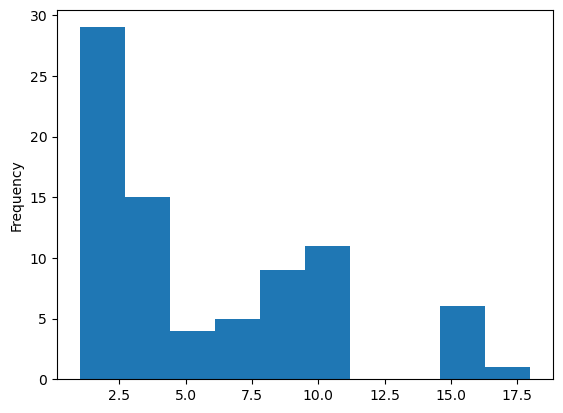

In [22]:

df_prices[df_prices['class'] == 'Economy']['days_left'].plot(kind='hist')


In [23]:
# dropping the flights which have high high price but without a meaninful reason accoridng to my opinion
row_to_drop=df[(df['class'] == 'Economy') & (df['days_left'] > 15) & (df['price'] > 30000)].index
df.drop(row_to_drop, axis=0, inplace=True)

## EDA

### distribution of categorical variable

In [24]:
for elem in df.columns[[0,2,3,4]]:
    print(f'{elem} : \n {df[elem].value_counts()}')

airline : 
 Vistara      127859
Air_India     80887
Indigo        43120
GO_FIRST      23172
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64
source_city : 
 Delhi        61340
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38697
Name: source_city, dtype: int64
departure_time : 
 Morning          71145
Early_Morning    66786
Evening          65101
Night            48015
Afternoon        47794
Late_Night        1306
Name: departure_time, dtype: int64
stops : 
 one            250857
zero            36004
two_or_more     13286
Name: stops, dtype: int64


In [25]:
for elem in df.columns[[5,6,7]]:
    print(f'{elem} : \n {df[elem].value_counts()}')
    

arrival_time : 
 Night            91537
Evening          78323
Morning          62733
Afternoon        38136
Early_Morning    15417
Late_Night       14001
Name: arrival_time, dtype: int64
destination_city : 
 Mumbai       59097
Delhi        57358
Bangalore    51066
Kolkata      49533
Hyderabad    42726
Chennai      40367
Name: destination_city, dtype: int64
class : 
 Economy     206660
Business     93487
Name: class, dtype: int64


plotting the distribution to better understand the caregories and how they are distributed

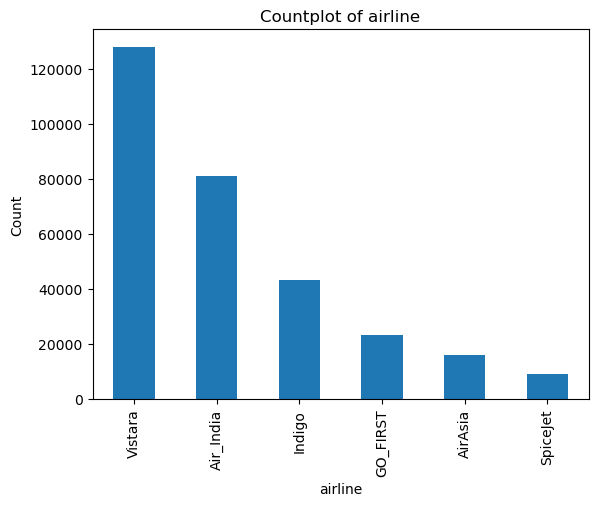

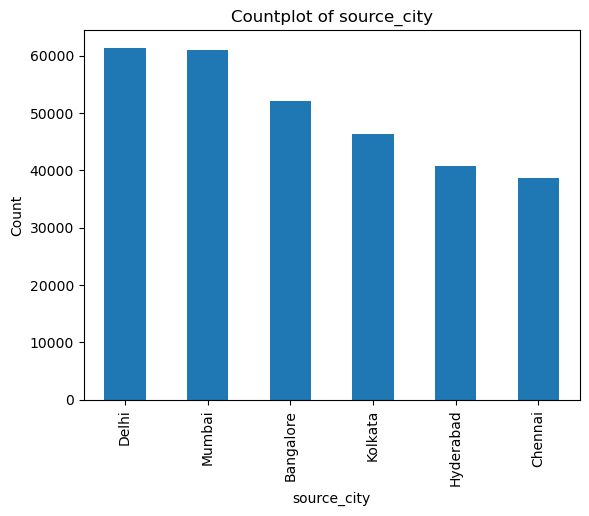

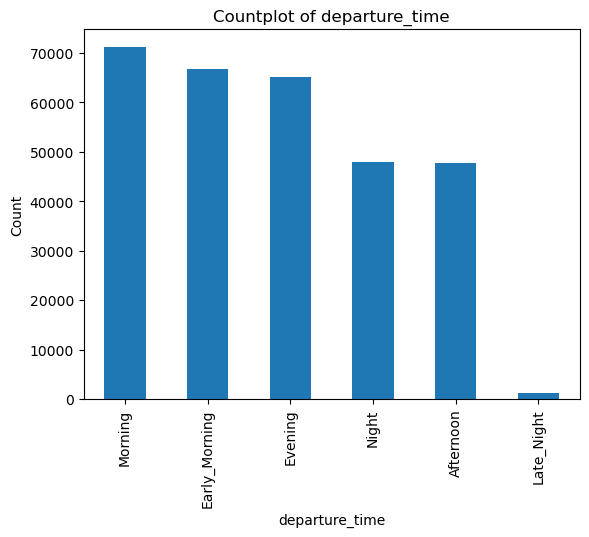

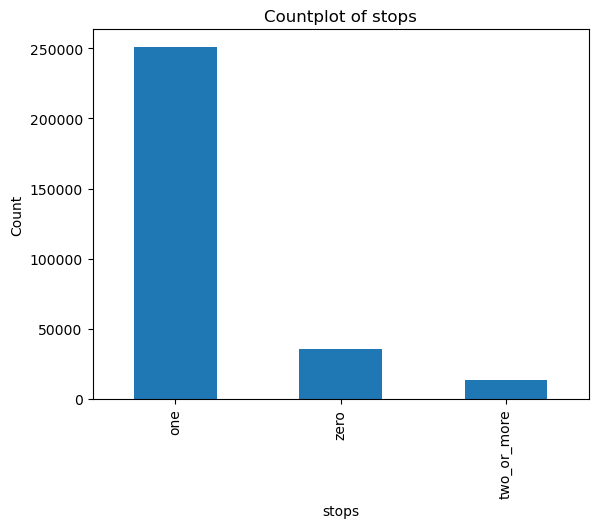

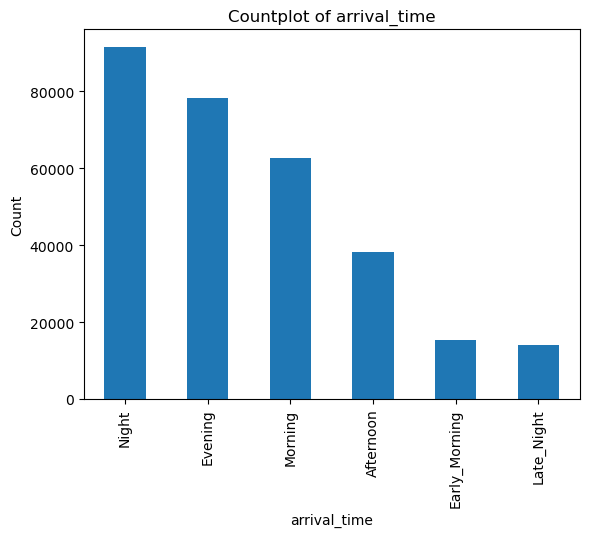

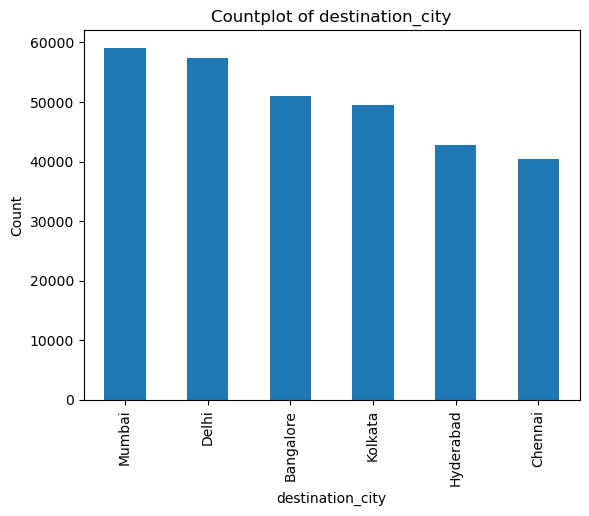

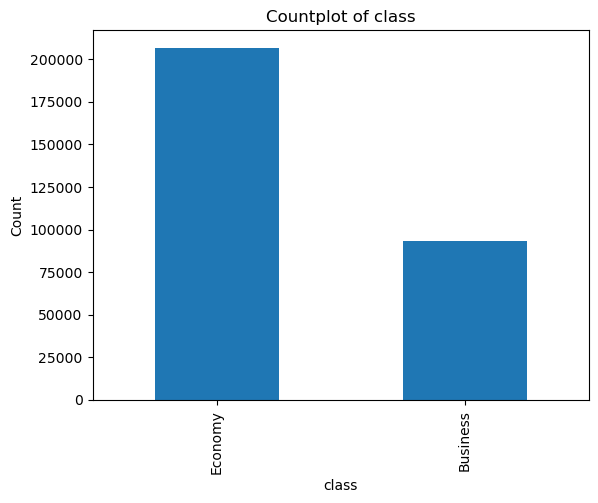

In [26]:
for elem in df.columns[[0,2,3,4,5,6,7]]:
    df[elem].value_counts().plot(kind='bar')
    plt.xlabel(elem)
    plt.ylabel('Count')
    plt.title(f'Countplot of {elem}')
    plt.show()
    

### distirbution of numerical variables

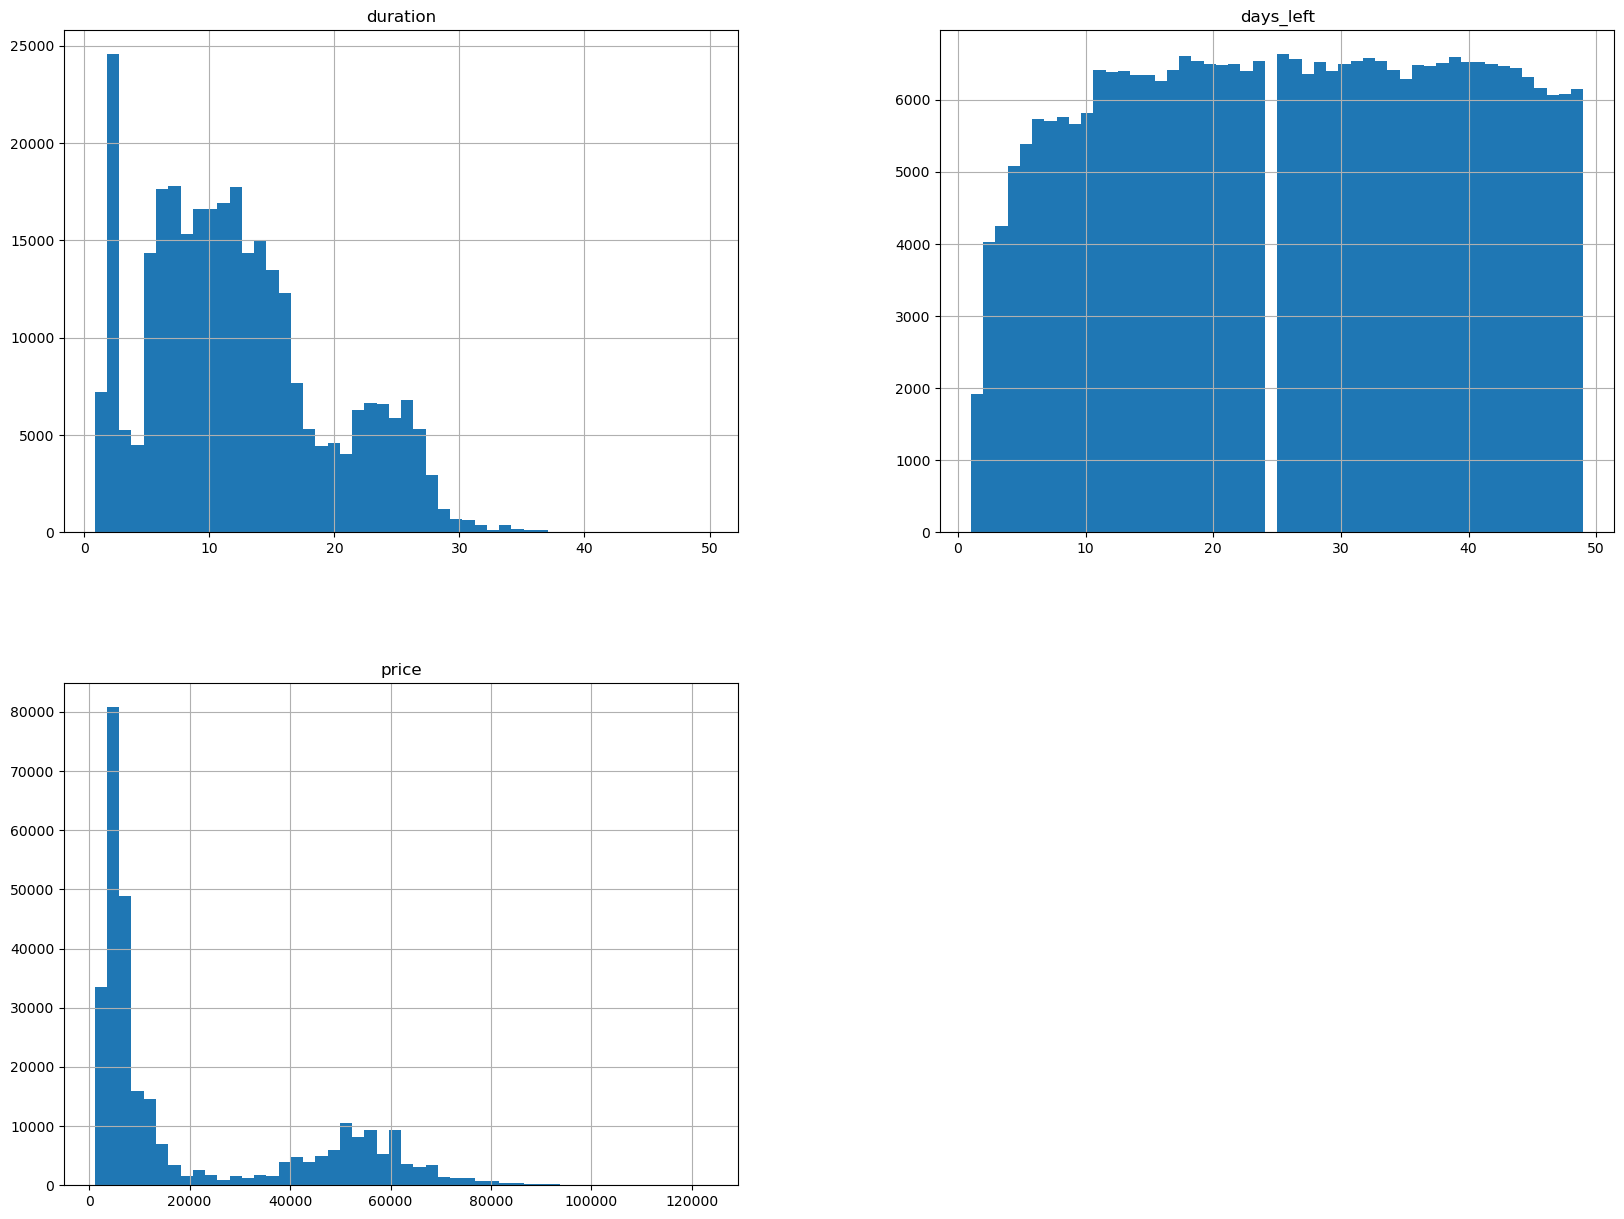

In [27]:
df.hist(bins=50, figsize=(20,15))
plt.show()

### Checking if there are interesting correlations

<Axes: >

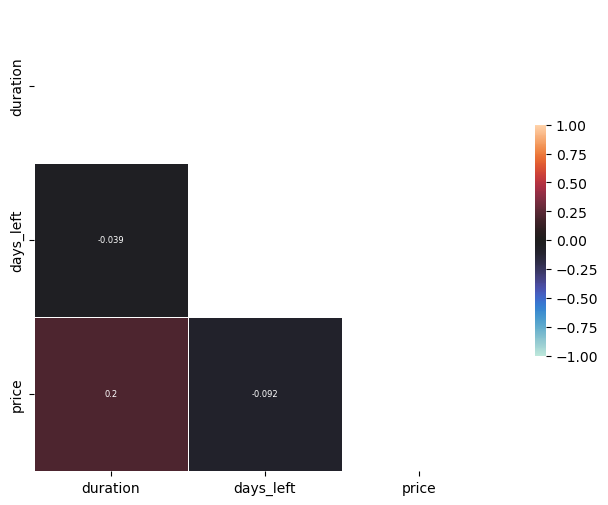

In [28]:
# Plotting the diagonal correlation matrix

# Compute correlation matrix
corr_matrix = df.corr()

# Generate a mask for the upper triangle. In order to visualize the diagonal 
# correlation matrix and not the entire once.
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, mask=mask, vmax= 1, vmin= -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={'fontsize': 6})

In [29]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

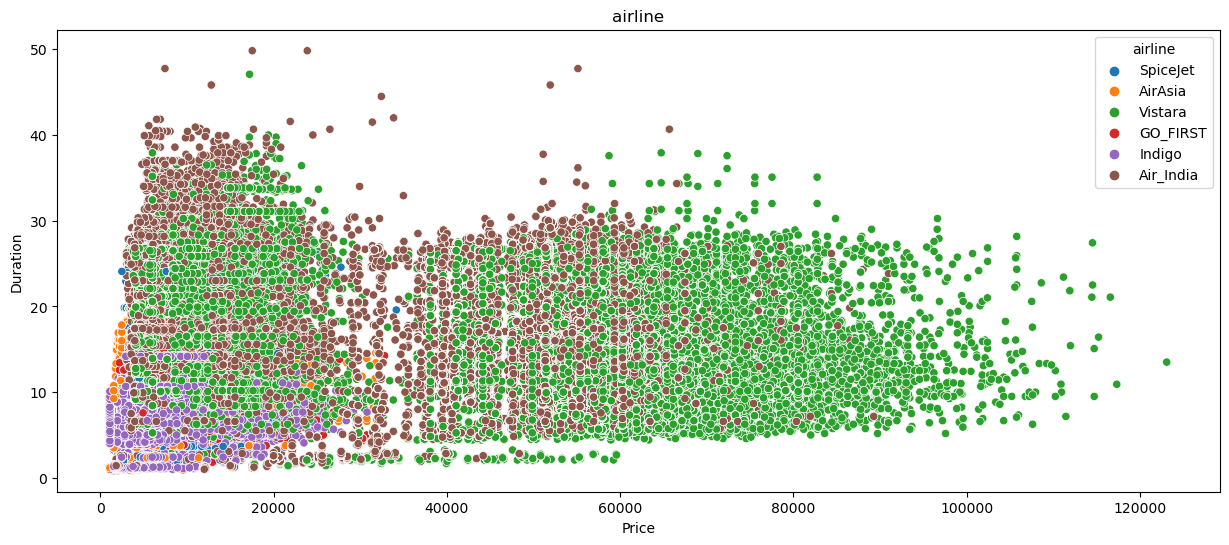

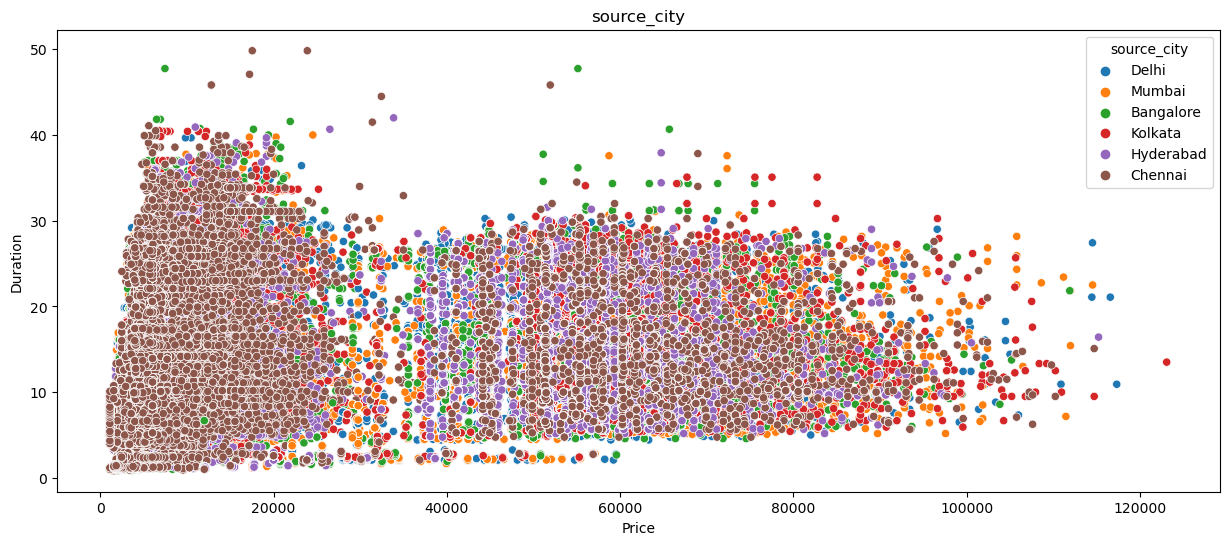

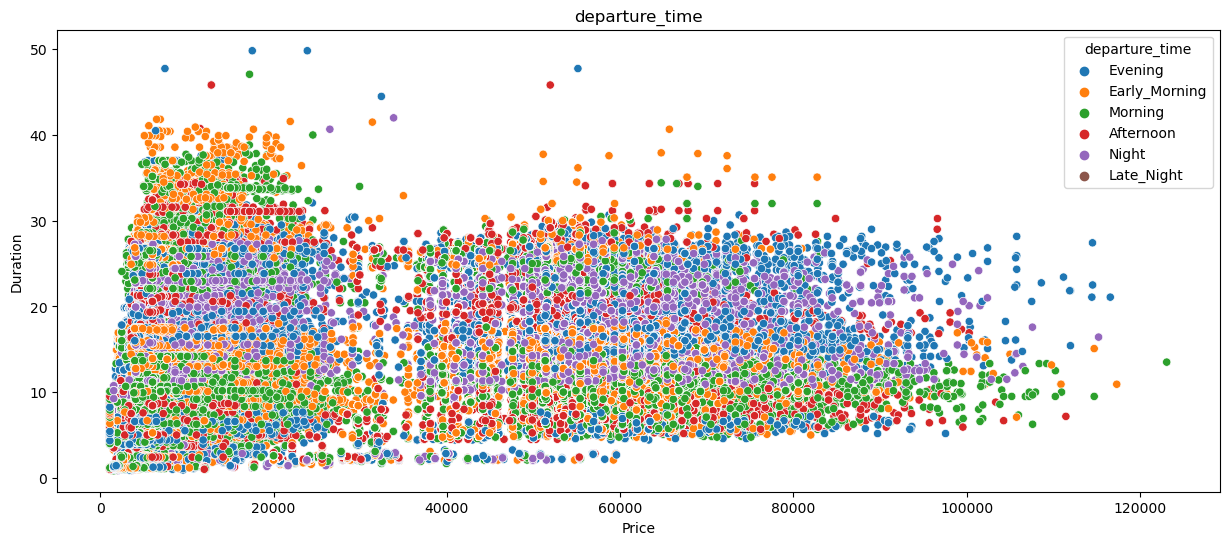

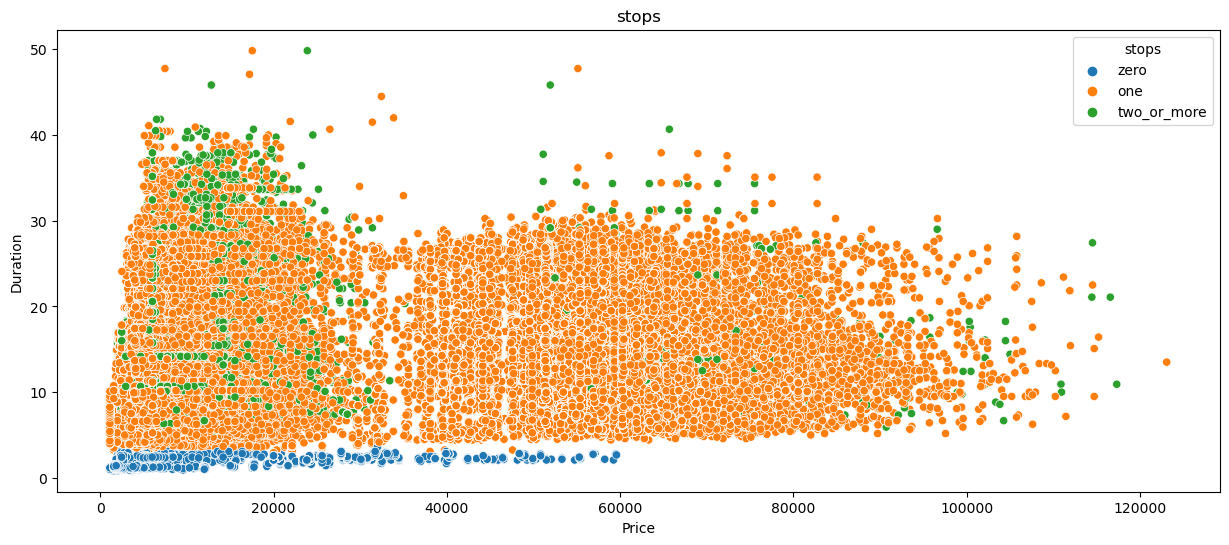

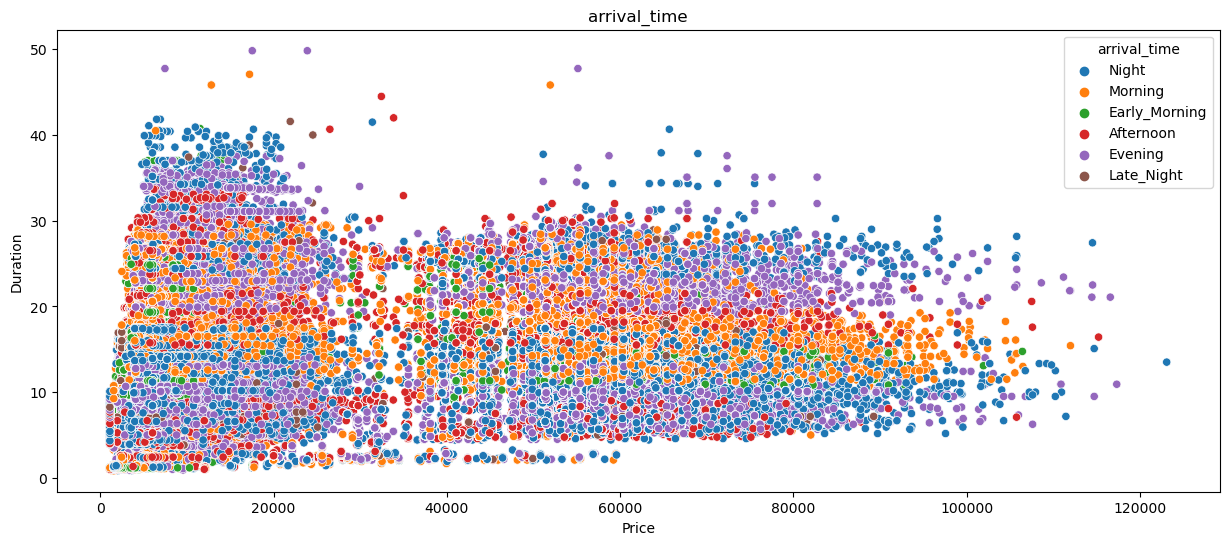

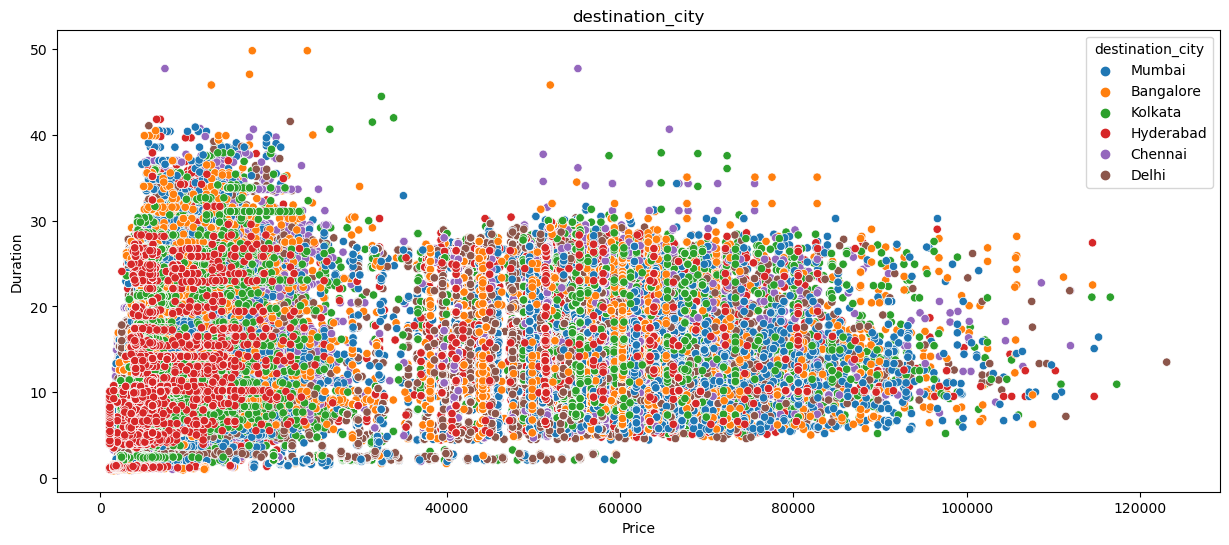

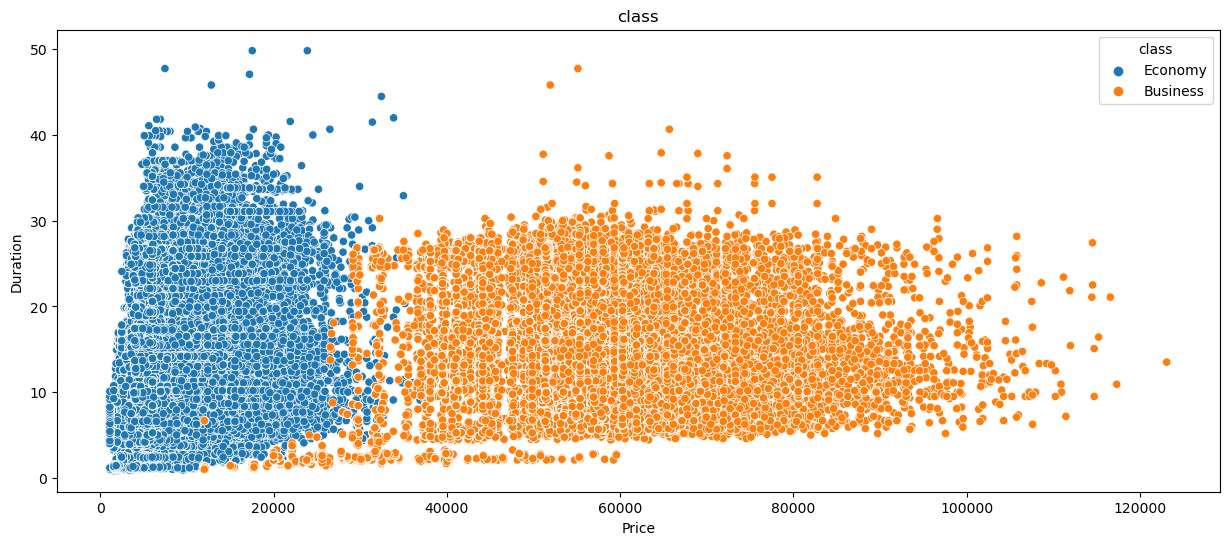

In [30]:
categorical_vars=['airline', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class',]

for elem in categorical_vars:
       plt.figure(figsize=(15,6))
       sns.scatterplot(data=df, x='price', y='duration', hue=elem)
       plt.xlabel('Price')
       plt.ylabel('Duration')
       plt.title(elem)
       plt.show()
    

it seams that type of airline, destionations and stops are the variables that are mostly related with the price of the flights.

<AxesSubplot: xlabel='days_left', ylabel='price'>

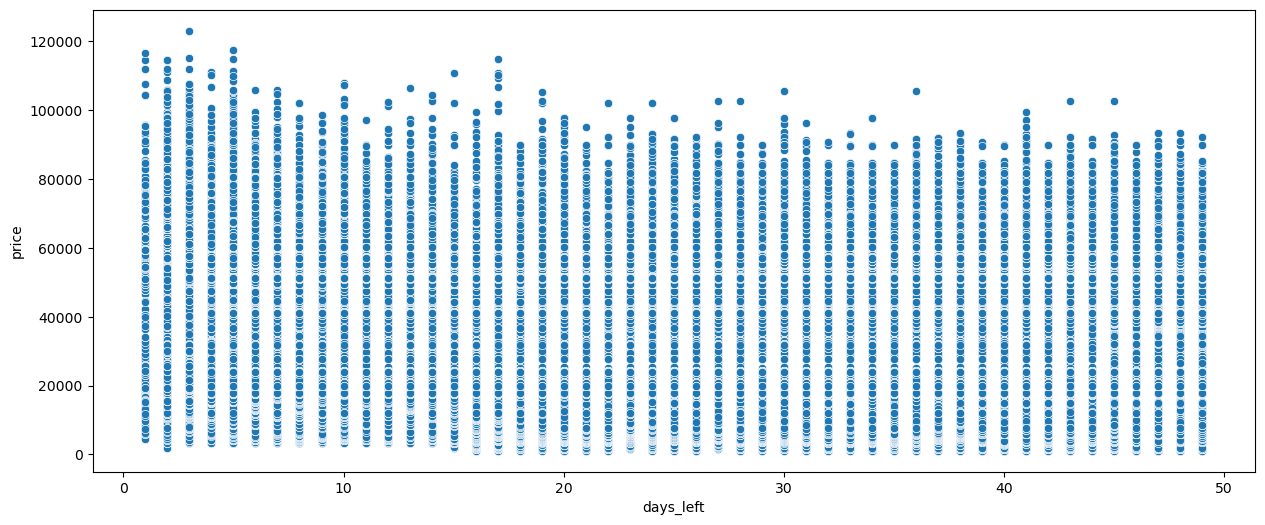

In [8]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=df, x='days_left', y='price')

it doesn't seem that days left afects that much the price of the flights

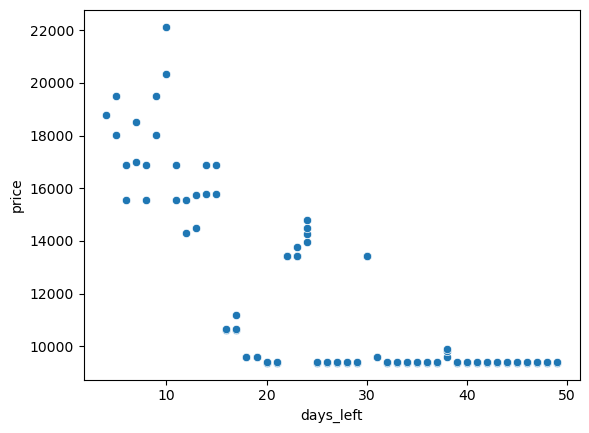

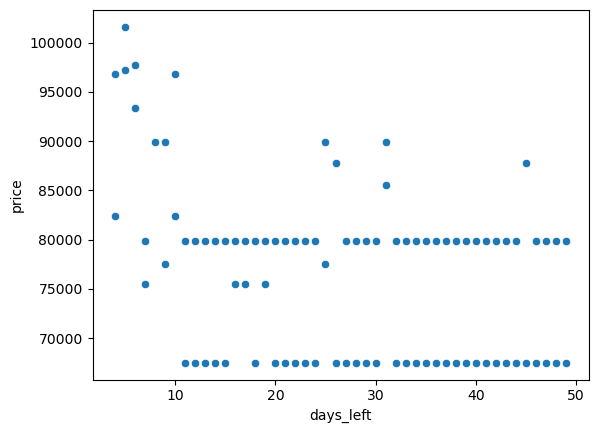

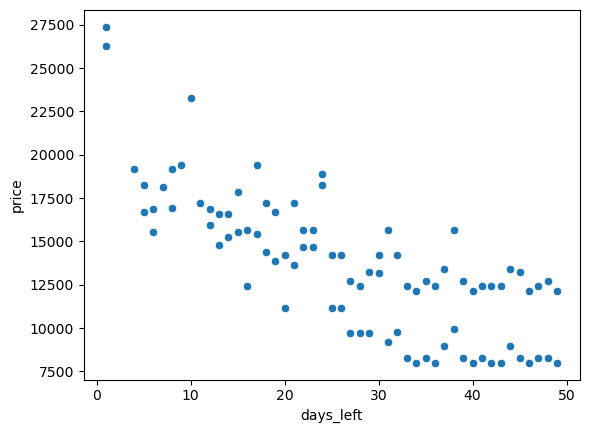

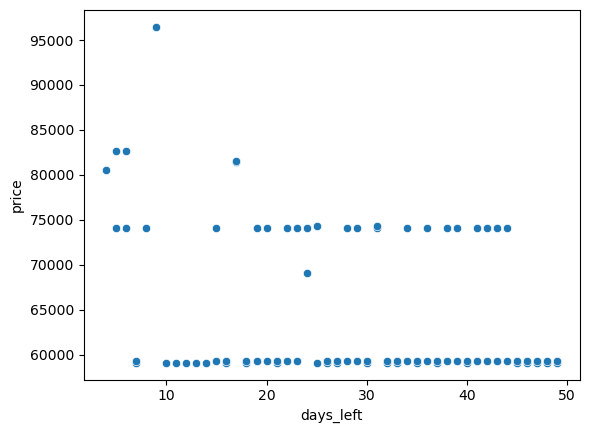

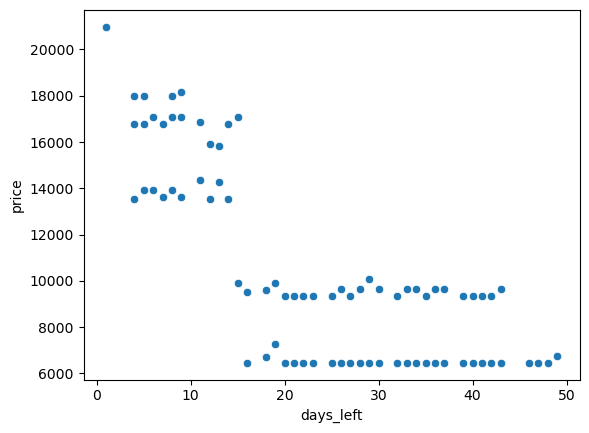

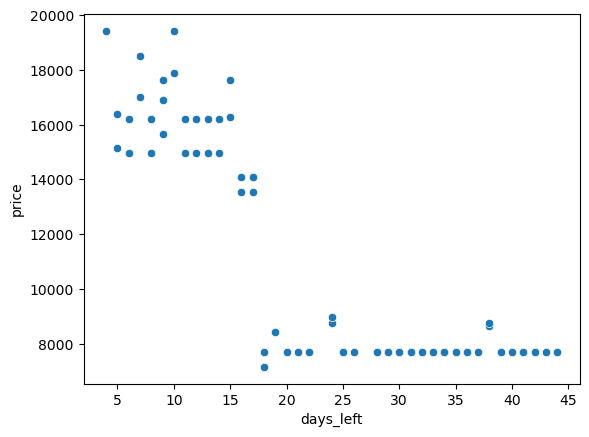

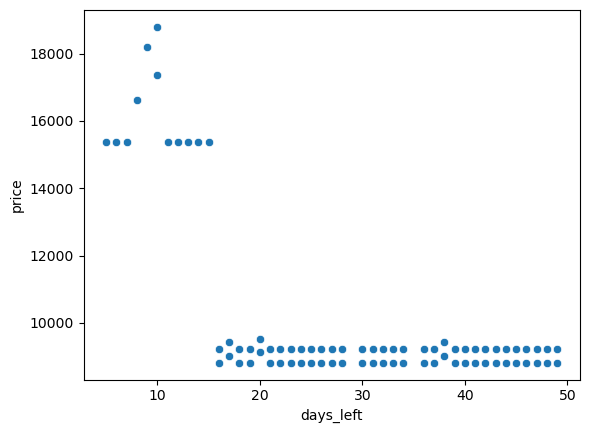

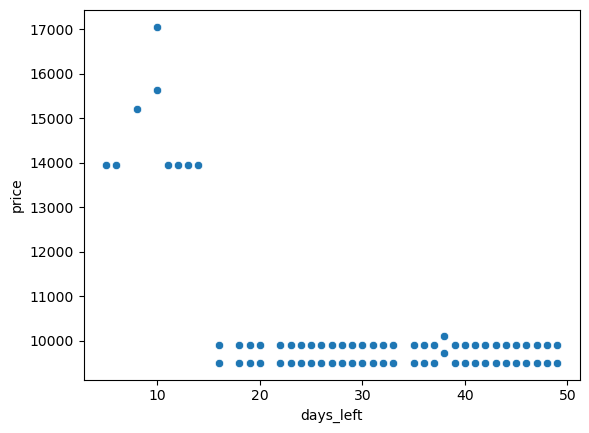

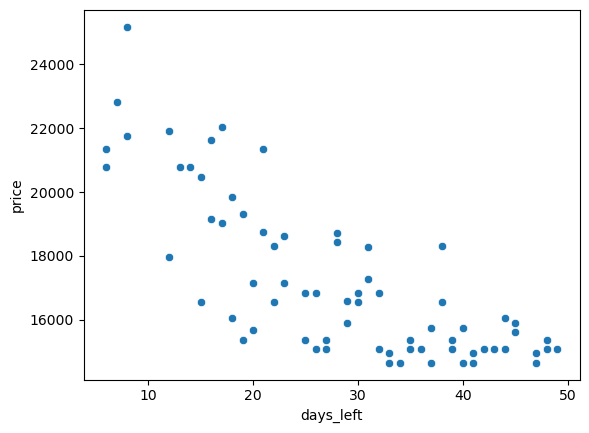

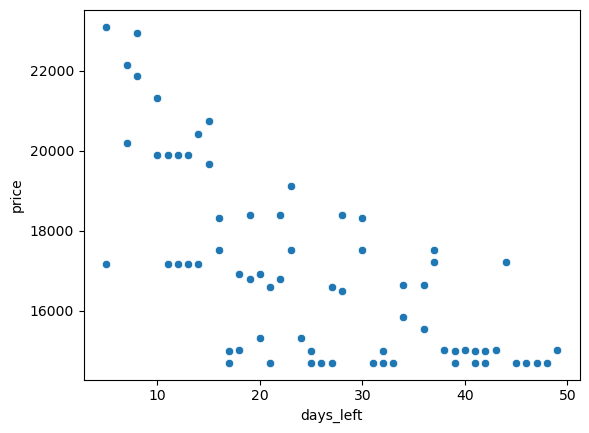

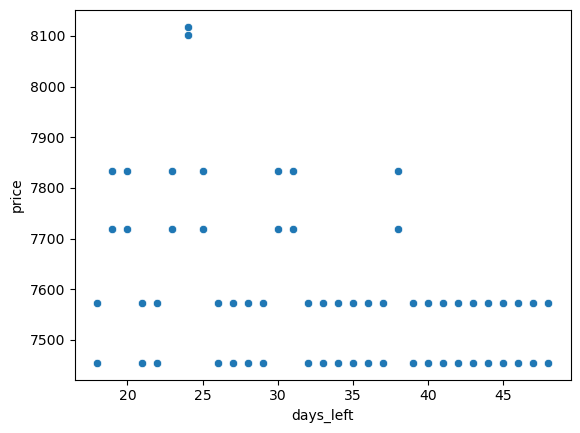

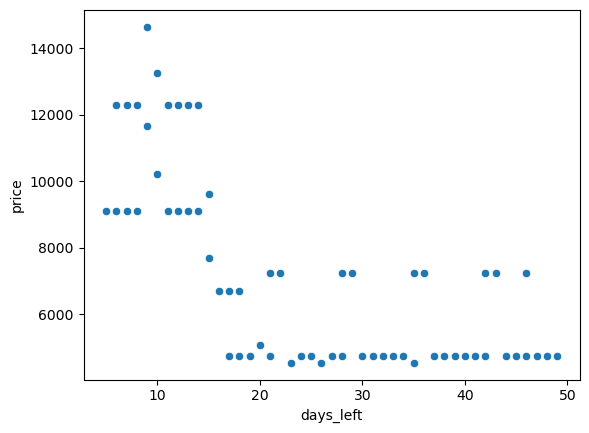

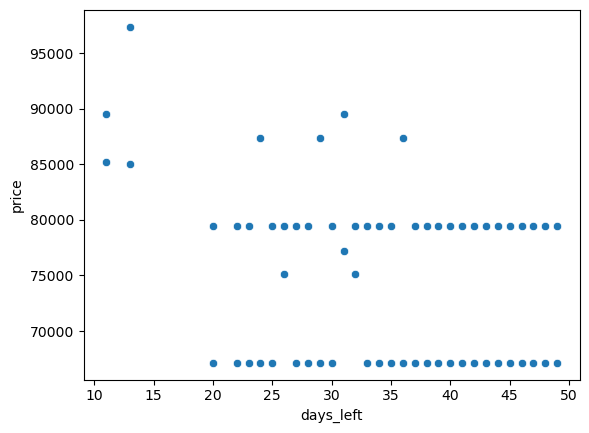

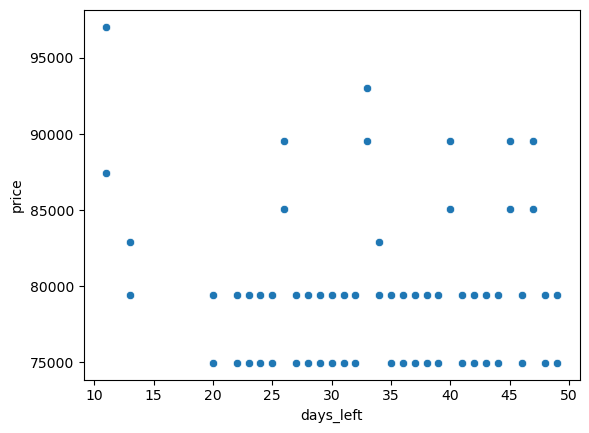

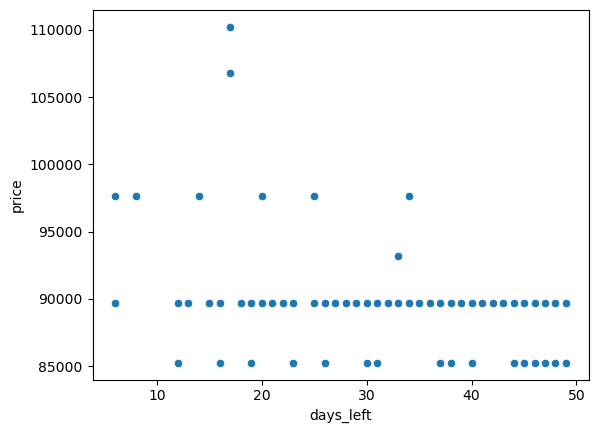

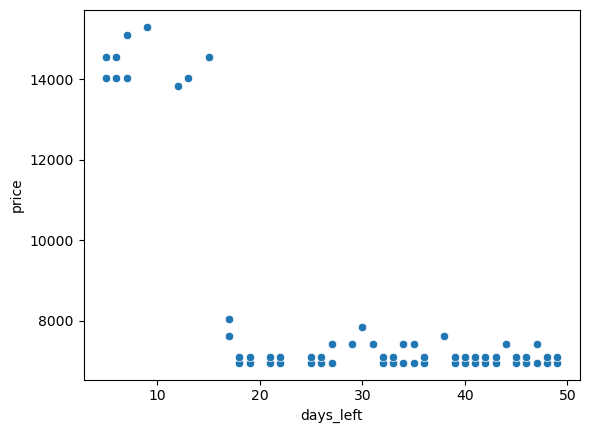

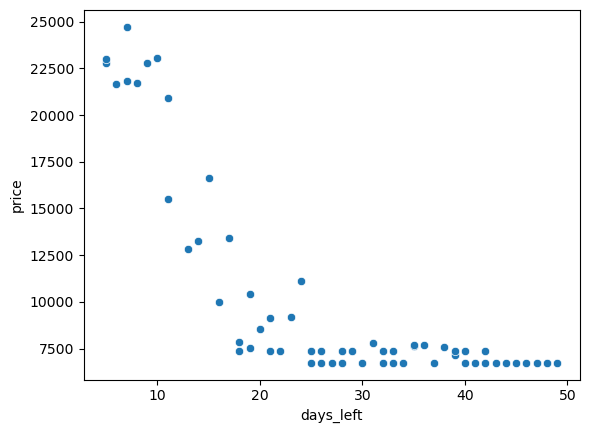

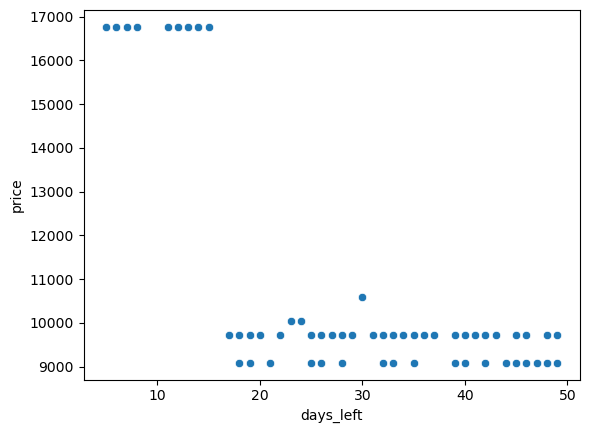

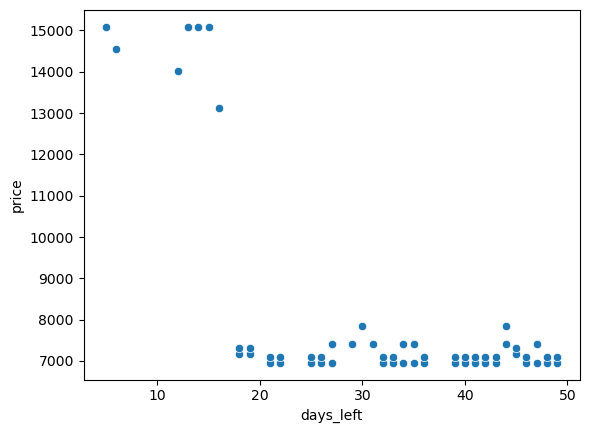

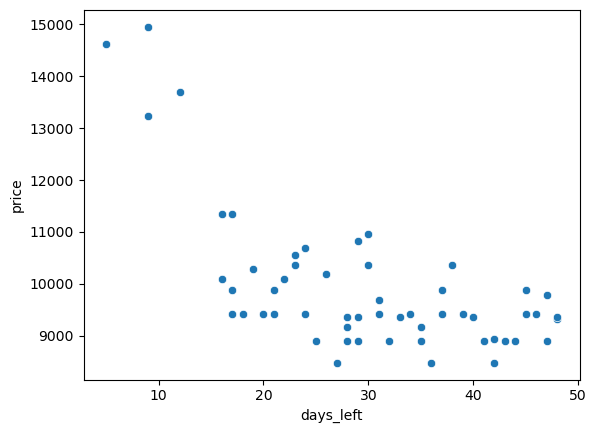

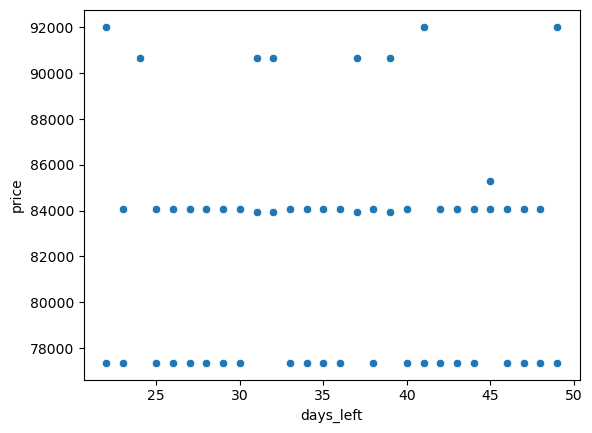

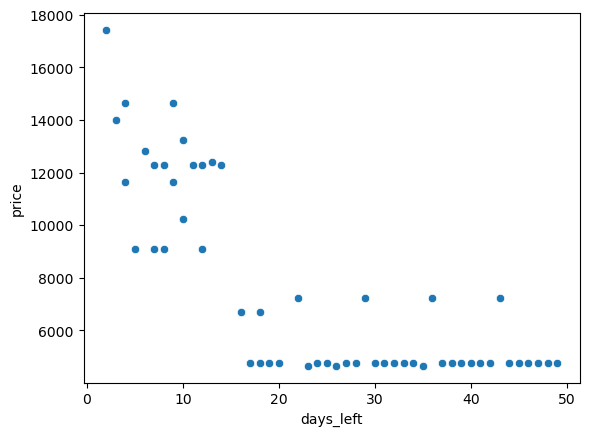

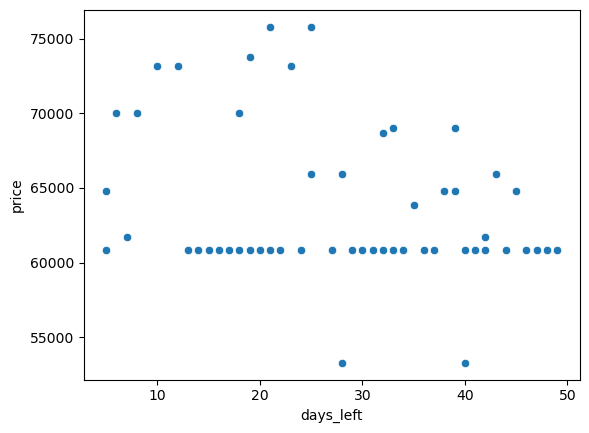

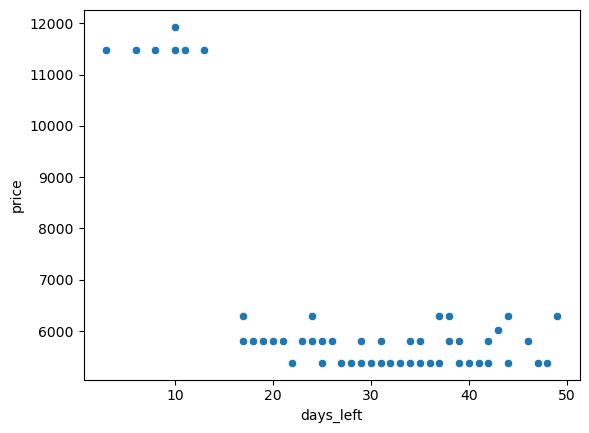

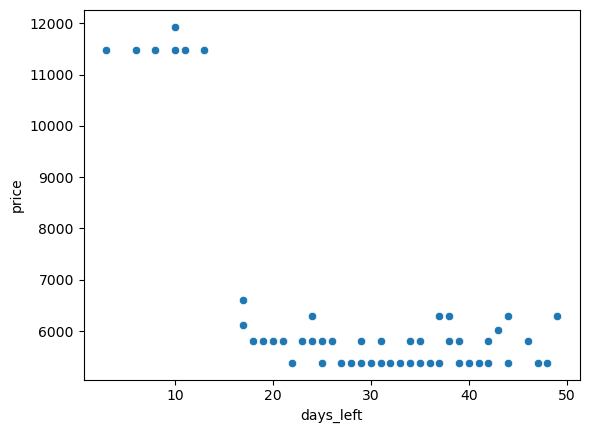

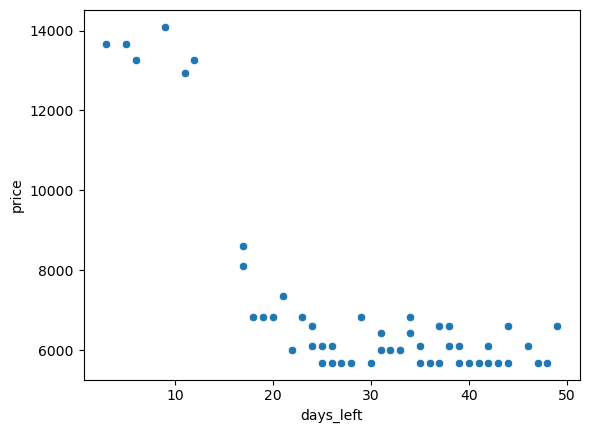

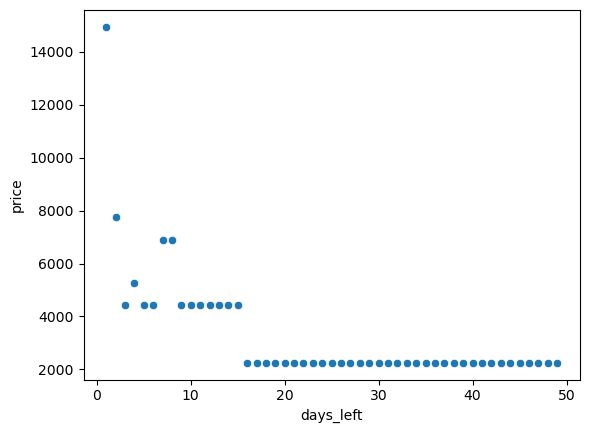

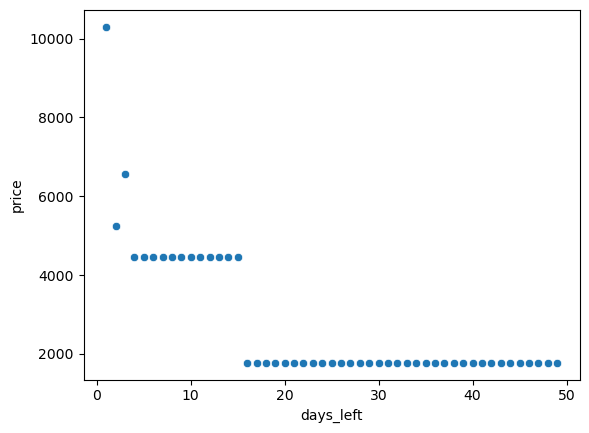

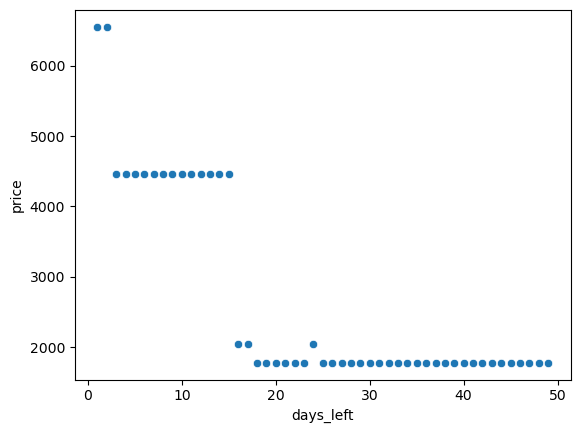

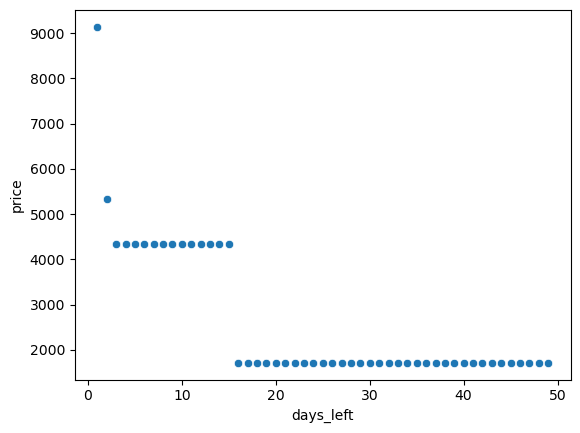

In [32]:
def sort_key(group):
    return len(group[1])

df_gruppato = df.groupby(['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration'])

sorted_groups = sorted(df_gruppato, key=sort_key, reverse=True)

for group_id, group_df in sorted_groups[:30]:
    sns.scatterplot(data=group_df, x='days_left', y='price')
    plt.show()

it seams that also days left has an impact on the price of the same type of ticket.

so wrapping up days left, airline, destination, class and stops seam to have an impact on the price of the flight tickets
This was kind of expected since the type of airline company can determine the prices of the tickets according to their policies, also the destination can have a posotive impact o t eh total price. Same thing is valid also for class because generally business class is more expensive than economy and as we saw also the number of days left can influence the price because as much time is left between the actual day and the flight departure as more the price is low. Especially we have seen how 15  day before the flight seems to be a treshold for the changing of the prices of the airplane tickets

# Modelling

## preparation

In [33]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [34]:
# we want to check if there is a carrelation between categrocial variables
from itertools import product

cat_var1=['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class']
cat_var2=['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class']

# creating a list of all the possible combinations of the categorical variables
cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))

import scipy.stats as ss

# creating an empty list to store the results of the chi2 test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(df[i[0]], df[i[1]])))[1]))

chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
## Using pivot function to convert the above DataFrame into a crosstab
chi_test_output.pivot(index='var1', columns='var2', values='coeff')


var2              airline  arrival_time         class  departure_time  \
var1                                                                    
airline               NaN           0.0  0.000000e+00             0.0   
arrival_time          0.0           NaN  0.000000e+00             0.0   
class                 0.0           0.0           NaN             0.0   
departure_time        0.0           0.0  0.000000e+00             NaN   
destination_city      0.0           0.0  6.660379e-50             0.0   
flight                0.0           0.0  0.000000e+00             0.0   
source_city           0.0           0.0  5.057456e-49             0.0   
stops                 0.0           0.0  0.000000e+00             0.0   

var2              destination_city  flight   source_city  stops  
var1                                                             
airline               0.000000e+00     0.0  0.000000e+00    0.0  
arrival_time          0.000000e+00     0.0  0.000000e+00    0.0  
class                 6.660379e-50     0.0  5.057456e-49    0.0  
departure_time        0.000000e+00     0.0  0.000000e+00    0.0  
destination_city               NaN     0.0  0.000000e+00    0.0  
flight                0.000000e+00     NaN  0.000000e+00    0.0  
source_city           0.000000e+00     0.0           NaN    0.0  
stops                 0.000000e+00     0.0  0.000000e+00    NaN

In [35]:
# dropping some columns that are not relevant for the purposes
df_modelli=df.drop(['flight', 'arrival_time'], axis=1)

### splitting the dataframe

In [9]:
# from sklearn.model_selection import StratifiedShuffleSplit

# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(df_modelli, df_modelli['class']):
#   strat_train_set = df_modelli.loc[train_index]
#   strat_test_set = df_modelli.loc[test_index]

In [37]:
from sklearn.model_selection import train_test_split
X=df_modelli.drop('price', axis=1)
y=df_modelli['price']
X_strat_train, X_strat_test, y_strat_train, y_strat_test = train_test_split(X, y,
                                                    stratify=df_modelli['class'], 
                                                    test_size=0.25)

### scaling and encoding

In [ ]:
df_modelli.describe()

duration      days_left          price
count  300153.000000  300153.000000  300153.000000
mean       12.221021      26.004751   20889.660523
std         7.191997      13.561004   22697.767366
min         0.830000       1.000000    1105.000000
25%         6.830000      15.000000    4783.000000
50%        11.250000      26.000000    7425.000000
75%        16.170000      38.000000   42521.000000
max        49.830000      49.000000  123071.000000

we need to scale the numerical variabbles and to encode the categorical ones

we will use a pipeline

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# storing the names of the numerical and categorical variables
num_var=list(df_modelli.columns[-3:-1])
cat_var=list(df_modelli.columns[:6])

# creating the pipeline
pipeline=ColumnTransformer([
    ('num', StandardScaler(), ['duration', 'days_left']),
    ('cat', OneHotEncoder(), ['airline','source_city','departure_time','stops','destination_city','class'])
])

# transforming the data
X_train=pipeline.fit_transform(X_strat_train)
y_train=y_strat_train.values
X_test=pipeline.transform(X_strat_test)
y_test=y_strat_test.values

X_train=pd.DataFrame(X_train.toarray())
X_test=pd.DataFrame(X_test.toarray())


### Modelli

#### Linar regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error


# Set up a regression model
lin_reg = LinearRegression()

# Fit the model on the training data
lin_reg.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = lin_reg.predict(X_test)

# Compute the mean absolute error and R-squared on the test set
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape=mean_absolute_percentage_error(y_test, y_pred)

print("Mean absolute error:", mae)
print("R-squared:", r2)
print("Mean Absolute Percentage Error:", mape)

Mean absolute error: 4595.798470790091
R-squared: 0.9102489671568157
Mean Absolute Percentage Error: 0.4626496541667778


#### Decison Trees

In [ ]:
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

# Set up a regression model
tree_reg = DecisionTreeRegressor()

# Fit the model on the training data
tree_reg.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = tree_reg.predict(X_test)

# Compute the mean absolute error and R-squared on the test set
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Percentage error:", mape)
print("Mean squared root error:", np.sqrt(mse))
print("R-squared:", r2)

Mean Absolute Percentage error: 0.07655431626294462
Mean squared root error: 3531.3802263999764
R-squared: 0.9758440070103326


#### Random Forrest

In [ ]:
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor


# Set up a regression model
forest_reg = RandomForestRegressor()

# Fit the model on the training data
forest_reg.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = tree_reg.predict(X_test)

# Compute the mean absolute error and R-squared on the test set
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Percentage error:", mape)
print("Mean squared root error:", np.sqrt(mse))
print("R-squared:", r2)

Mean Absolute Percentage error: 0.07655431626294462
Mean squared root error: 3531.3802263999764
R-squared: 0.9758440070103326


#### CV Linear Regression

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer


lin_reg = LinearRegression()
nmape_scorer = make_scorer(mean_absolute_percentage_error)

scores = cross_val_score(lin_reg, X_train, y_train,
scoring=nmape_scorer, cv=10)
linear_scores = scores
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(linear_scores)

Scores: [0.45959142 0.46338453 0.46714671 0.4675749  0.46278376 0.4616758
 0.46152168 0.46203822 0.45534277 0.46135942]
Mean: 0.4622419211169044
Standard deviation: 0.003322344235551581


#### Trying optuna rather than grid search for random forest

In [ ]:
import optuna
from sklearn.metrics import  mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    # Create a Random Forest model with the suggested hyperparameters
    model = RandomForestRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mape

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization process
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and the best score
best_params = study.best_params
best_score = study.best_value
print('Best Hyperparameters:', best_params)
print('Best Score (MAPE):', best_score)

[I 2023-06-13 16:40:56,360] A new study created in memory with name: no-name-9645c34b-cf3e-419c-a814-d80f2e968106
[I 2023-06-13 16:43:12,492] Trial 0 finished with value: 0.24205333396587342 and parameters: {'n_estimators': 800, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.24205333396587342.
[I 2023-06-13 16:45:07,841] Trial 1 finished with value: 0.20041988319299836 and parameters: {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.20041988319299836.
[I 2023-06-13 16:48:02,856] Trial 2 finished with value: 0.17981846525475867 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.17981846525475867.
[I 2023-06-13 16:49:59,570] Trial 3 finished with value: 0.20039533726832498 and parameters: {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 2 with

Best Hyperparameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 9}
Best Score (MAPE): 0.17972182436887668


In [ ]:
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

params=best_params

# Set up a regression model
forest_reg = RandomForestRegressor(**params)
#forest_reg = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=8, min_samples_leaf=9)


# Fit the model on the training data
forest_reg.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = tree_reg.predict(X_test)

# Compute the mean absolute error and R-squared on the test set
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Percentage error:", mape)
print("Mean squared root error:", np.sqrt(mse))
print("R-squared:", r2)

Mean Absolute Percentage error: 0.07655431626294462
Mean squared root error: 3531.3802263999764
R-squared: 0.9758440070103326


#### XGBoost

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor


def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'subsample': trial.suggest_float('subsample', 0.05, 1, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1, step=0.05),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=10),
        'alpha': trial.suggest_float('alpha', 0, 1 , step=0.05),
        'objective': 'reg:squarederror'
    }

    # Create an XGBoost model with the suggested hyperparameters
    model = XGBRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mape



# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization process
study.optimize(objective, n_trials=200)

# Print the best hyperparameters and the best score
best_params_xgb = study.best_params
best_score_xgb = study.best_value
print('Best Hyperparameters:', best_params_xgb)
print('Best Score (MAPE):', best_score_xgb)

[I 2023-06-14 11:55:49,845] A new study created in memory with name: no-name-5eefa4ff-85ad-4904-9a27-0d548fb63ba0
[I 2023-06-14 11:55:53,362] Trial 0 finished with value: 0.19408420530993012 and parameters: {'learning_rate': 0.6, 'max_depth': 4, 'subsample': 0.6500000000000001, 'colsample_bytree': 0.3, 'n_estimators': 100, 'alpha': 0.75}. Best is trial 0 with value: 0.19408420530993012.
[I 2023-06-14 11:55:57,219] Trial 1 finished with value: 0.20012409881040663 and parameters: {'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.25, 'n_estimators': 170, 'alpha': 0.2}. Best is trial 0 with value: 0.19408420530993012.
[I 2023-06-14 11:56:01,123] Trial 2 finished with value: 0.18828814053366938 and parameters: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'n_estimators': 80, 'alpha': 0.8500000000000001}. Best is trial 2 with value: 0.18828814053366938.
[I 2023-06-14 11:56:09,267] Trial 3 finished 

Best Hyperparameters: {'learning_rate': 0.4, 'max_depth': 8, 'subsample': 0.9500000000000001, 'colsample_bytree': 1.0, 'n_estimators': 200, 'alpha': 0.0}
Best Score (MAPE): 0.10192453162388967


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

params=best_params_xgb

y_train = y_train.astype(float)
y_test = y_test.astype(float)

y_train = y_train.ravel()
y_test = y_test.ravel()

# Create an XGBoost model with the suggested hyperparameters
model = XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Percentage error:", mape)
print("R-squared:", r2)

Mean Absolute Percentage error: 0.10192453162388967
R-squared: 0.9872174297212702


#### Catboost

In [ ]:
import catboost as cb
from sklearn.metrics import mean_absolute_percentage_error


# Create a CatBoost classifier
model = cb.CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss')

# Fit the model on the training data
model.fit(X_train, y_train, cat_features=[])

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model on the validation set
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Percentage error:", mape)
print("R-squared:", r2)


In [10]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Assuming X_train, X_test, y_train, and y_test are defined
# y_train = y_train.astype(float)
# y_test = y_test.astype(float)

# y_train = y_train.ravel()
# y_test = y_test.ravel()

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'num_trees':trial.suggest_int('num_treees', 10, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'subsample': trial.suggest_float('subsample', 0.05, 1, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1, step=0.05),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0, step=0.1),
        'alpha': trial.suggest_float('alpha', 0, 1 , step=0.05),
        'objective': 'reg:squarederror'
    }

    # Create an XGBoost model with the suggested hyperparameters
    model = CatBoostRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mape



# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization process
study.optimize(objective, n_trials=200)

# Print the best hyperparameters and the best score
best_params_xgb = study.best_params
best_score_xgb = study.best_value
print('Best Hyperparameters:', best_params_xgb)
print('Best Score (MAPE):', best_score_xgb)